In [1]:

import pandas as pd
import numpy as np
import nbimporter
import feature_engineering
from datetime import datetime, timedelta
from functools import reduce
import glob
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Preprocessing

In [2]:
%run Preprocessing.ipynb

## 1.1 Climate Data

### 1.1.1 Climate Data - Import 

In [3]:
climate_data = ["Temperature", "Precipitation"]
station_names = ["Berlin", "BW", "NRW"]
temp_path = r"C:\Users\Isabell\EMSI\emsi_ml\Wetter"
file_name = "produkt*"
date_column = "MESS_DATUM"
date_format = '%Y%m%d%H%M'

station_climate_list = []

for station in station_names:
    for data in climate_data:
        file_path =rf"{temp_path}\{station}\{data}"
        #print(file_path)
        temperature_dic = importing_climate_data(file_path, file_name, date_column, date_format)
        #print(temperature_dic)
        station_climate_list.append(temperature_dic)

print(station_climate_list[-1])
#print("done")

{2012:         NRW_STATIONS_ID  NRW_MESS_DATUM  NRW_  QN  NRW_RWS_DAU_10  NRW_RWS_10  \
105120             2667    201201010000         3               0         0.0   
105121             2667    201201010010         3               2         0.0   
105122             2667    201201010020         3               8         0.0   
105123             2667    201201010030         3               7         0.0   
105124             2667    201201010040         3               1         0.0   
...                 ...             ...       ...             ...         ...   
157819             2667    201212312310         3               0         0.0   
157820             2667    201212312320         3               0         0.0   
157821             2667    201212312330         3               0         0.0   
157822             2667    201212312340         3               0         0.0   
157823             2667    201212312350         3               0         0.0   

        NRW_RWS_IND_

### 1.1.2 Climate Data - Downsampling to 15min steps

In [4]:
climate_resampled = []
for station in station_climate_list:
    resampled_dic = resampling_data(station, "15T")
    climate_resampled.append(resampled_dic)

print(climate_resampled[-1])
print("done")

{2012:                      NRW_STATIONS_ID  NRW_MESS_DATUM  NRW_  QN  \
DateTime                                                         
2012-01-01 00:00:00           2667.0    2.012010e+11       3.0   
2012-01-01 00:15:00           2667.0    2.012010e+11       3.0   
2012-01-01 00:30:00           2667.0    2.012010e+11       3.0   
2012-01-01 00:45:00           2667.0    2.012010e+11       3.0   
2012-01-01 01:00:00           2667.0    2.012010e+11       3.0   
...                              ...             ...       ...   
2012-12-31 22:45:00           2667.0    2.012123e+11       3.0   
2012-12-31 23:00:00           2667.0    2.012123e+11       3.0   
2012-12-31 23:15:00           2667.0    2.012123e+11       3.0   
2012-12-31 23:30:00           2667.0    2.012123e+11       3.0   
2012-12-31 23:45:00           2667.0    2.012123e+11       3.0   

                     NRW_RWS_DAU_10  NRW_RWS_10  NRW_RWS_IND_10 NRW_eor  
DateTime                                                    

## 1.2 Football Data

### 1.2.1 Football Data - Importing

In [5]:

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'



football_dic = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)
print(football_dic)

    

{2021:               Land1            Land2          Runde       Datum  \
0           Türkei           Italien   Gruppenphase  11. Jun 21   
1            Wales           Schweiz   Gruppenphase  12. Jun 21   
2         Dänemark          Finnland   Gruppenphase  12. Jun 21   
3          Belgien          Russland   Gruppenphase  12. Jun 21   
4          England          Kroatien   Gruppenphase  13. Jun 21   
5       Österreich    Nordmazedonien   Gruppenphase  13. Jun 21   
6      Niederlande           Ukraine   Gruppenphase  13. Jun 21   
7       Schottland        Tschechien   Gruppenphase  14. Jun 21   
8            Polen          Slowakei   Gruppenphase  14. Jun 21   
9          Spanien          Schweden   Gruppenphase  14. Jun 21   
10          Ungarn          Portugal   Gruppenphase  15. Jun 21   
11      Frankreich       Deutschland   Gruppenphase  15. Jun 21   
12        Finnland          Russland   Gruppenphase  16. Jun 21   
13          Türkei             Wales   Gruppenphase  16

### 1.2.2 Football Data - Adding new columns for Matches at same time

In [6]:

football_dic_new = {}
for key, match_set in football_dic.items():

    results = new_col_match(match_set)        
        
    results.set_index("DateTime")
    football_dic_new[key] = results

print(football_dic_new[2024])

             DateTime    Land1  Land2         Runde Liga    Land3   Land4
0 2021-06-20 18:00:00  Italien  Wales  Gruppenphase   EM  Schweiz  Türkei
          Land1           Land2         Runde Liga            DateTime  \
0        Türkei         Italien  Gruppenphase   EM 2021-06-11 21:00:00   
1         Wales         Schweiz  Gruppenphase   EM 2021-06-12 15:00:00   
2      Dänemark        Finnland  Gruppenphase   EM 2021-06-12 18:00:00   
3       Belgien        Russland  Gruppenphase   EM 2021-06-12 21:00:00   
4       England        Kroatien  Gruppenphase   EM 2021-06-13 15:00:00   
5    Österreich  Nordmazedonien  Gruppenphase   EM 2021-06-13 18:00:00   
6   Niederlande         Ukraine  Gruppenphase   EM 2021-06-13 21:00:00   
7    Schottland      Tschechien  Gruppenphase   EM 2021-06-14 15:00:00   
8         Polen        Slowakei  Gruppenphase   EM 2021-06-14 18:00:00   
9       Spanien        Schweden  Gruppenphase   EM 2021-06-14 21:00:00   
10       Ungarn        Portugal  Grupp

## 1.3 Electricity Data

### 1.3.1 Electricity Data - Importing and converting MWh to floats

In [7]:
temp_path =r"Stromverbrauch\Viertel"
file_name = "*.csv"
date_column = "Datum von"
date_format = "%d.%m.%Y %H:%M"

elec_dic = importing_electricity_data(temp_path, file_name, date_column, date_format)



## 1.4 Merging Dataframes, dropping unwanted columns, filling nans with during match with data from football dataset

In [8]:
dfs = []

unwantend_col_string = ["QN", "MESS_DATUM", 'Datum von', 'Datum bis', "eor", "STATIONS"]
#print(climate_resampled)
for key, elec in elec_dic.items():
    football = football_dic_new[key]
    electricity = elec
    climate_data = []
    for station in climate_resampled:
        climate_data.append(pd.DataFrame(station[key])) 

    merged_df = merging_data(electricity, football, climate_data, unwantend_col_string)
                       
    dfs.append(merged_df)

endresult_df = pd.concat(dfs, ignore_index = True)

print(endresult_df)


      Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime  \
0                                        11930.50 2016-06-10 00:00:00   
1                                        11764.50 2016-06-10 00:15:00   
2                                        11602.50 2016-06-10 00:30:00   
3                                        11495.00 2016-06-10 00:45:00   
4                                        11384.25 2016-06-10 01:00:00   
...                                           ...                 ...   
9019                                     12060.00 2021-07-11 22:45:00   
9020                                     11943.25 2021-07-11 23:00:00   
9021                                     11795.50 2021-07-11 23:15:00   
9022                                     11620.00 2021-07-11 23:30:00   
9023                                     11508.25 2021-07-11 23:45:00   

        Land1    Land2   Runde Liga Land3 Land4  Berlin_PP_10  Berlin_TT_10  \
0         NaN      NaN     NaN  NaN   NaN   

# 2. Feature Engineering

In [9]:
%run feature_engineering.ipynb

## 2.1 Correlation matrix

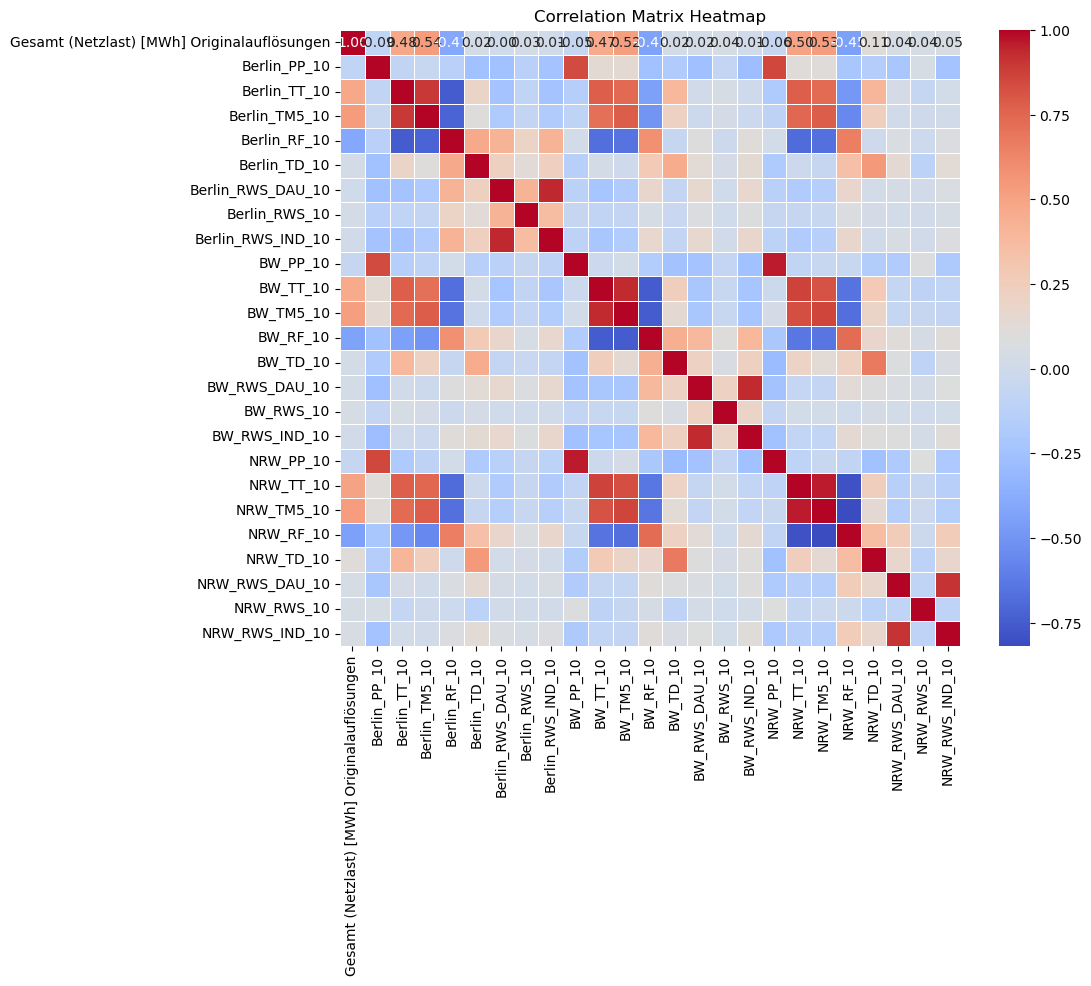

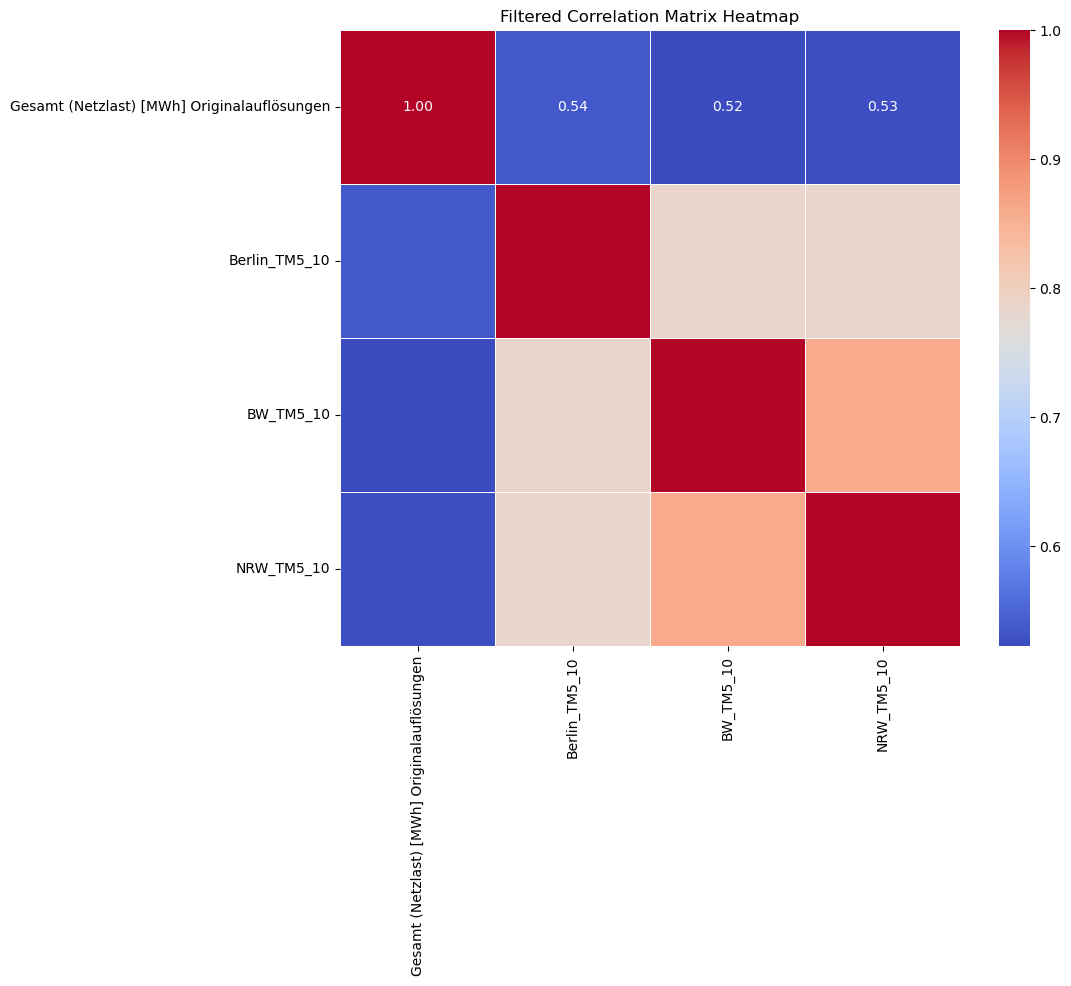

      Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime  \
0                                        11930.50 2016-06-10 00:00:00   
1                                        11764.50 2016-06-10 00:15:00   
2                                        11602.50 2016-06-10 00:30:00   
3                                        11495.00 2016-06-10 00:45:00   
4                                        11384.25 2016-06-10 01:00:00   
...                                           ...                 ...   
9019                                     12060.00 2021-07-11 22:45:00   
9020                                     11943.25 2021-07-11 23:00:00   
9021                                     11795.50 2021-07-11 23:15:00   
9022                                     11620.00 2021-07-11 23:30:00   
9023                                     11508.25 2021-07-11 23:45:00   

        Land1    Land2   Runde Liga Land3 Land4  Berlin_TM5_10  BW_TM5_10  \
0         NaN      NaN     NaN  NaN   NaN   Na

In [10]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
cut_off_limit = 0.5
#print(endresult_df)
#endresult_df.set_index("DateTime")
corr_df_input = endresult_df.copy()
df_filtered = correlation_matrix(corr_df_input, categorical_columns, cut_off_limit)
print(df_filtered)

## 2.2 Reducing dimensionality

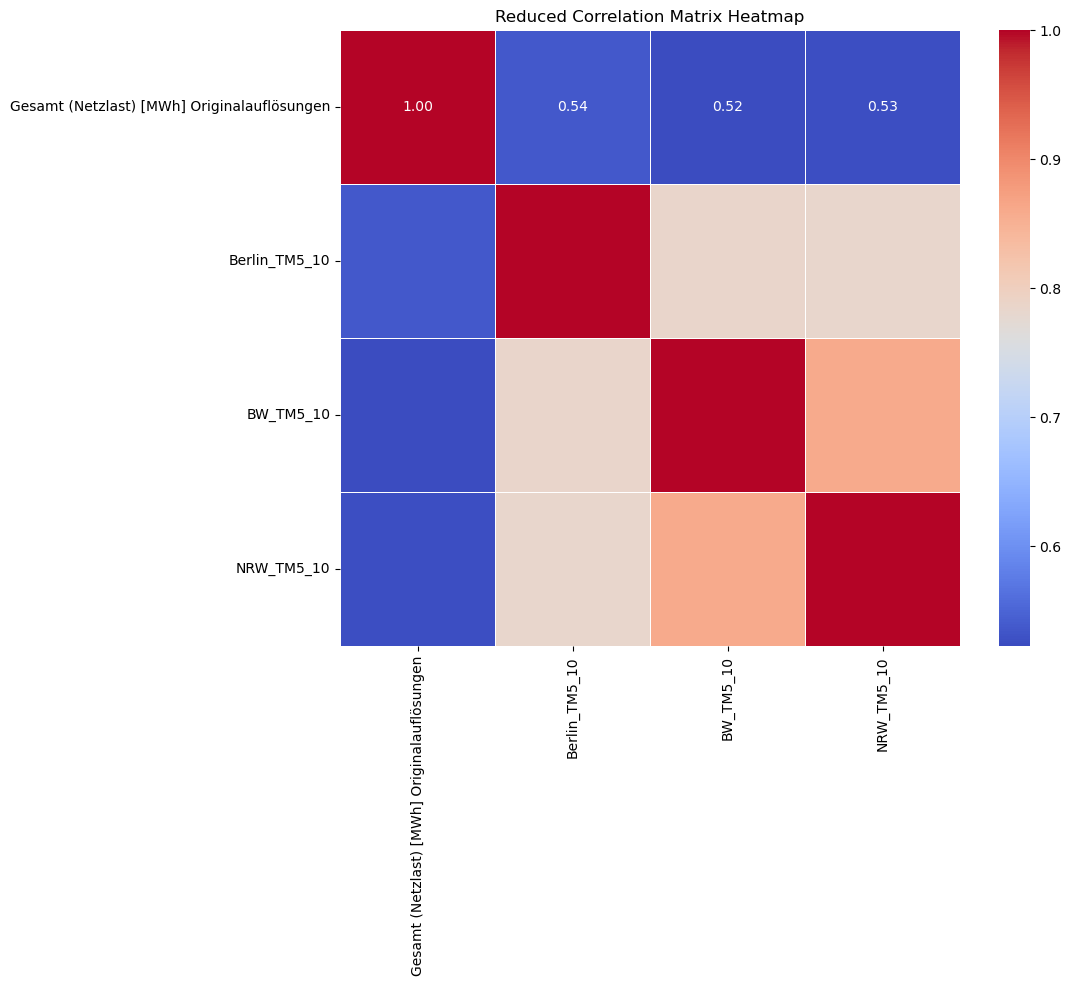

      Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime  \
0                                        11930.50 2016-06-10 00:00:00   
1                                        11764.50 2016-06-10 00:15:00   
2                                        11602.50 2016-06-10 00:30:00   
3                                        11495.00 2016-06-10 00:45:00   
4                                        11384.25 2016-06-10 01:00:00   
...                                           ...                 ...   
9019                                     12060.00 2021-07-11 22:45:00   
9020                                     11943.25 2021-07-11 23:00:00   
9021                                     11795.50 2021-07-11 23:15:00   
9022                                     11620.00 2021-07-11 23:30:00   
9023                                     11508.25 2021-07-11 23:45:00   

        Land1    Land2   Runde Liga Land3 Land4  Berlin_TM5_10  BW_TM5_10  \
0         NaN      NaN     NaN  NaN   NaN   Na

In [11]:
# Set the correlation threshold
correlation_threshold = 0.9 # Adjust this threshold as needed
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]
#print(df_filtered)
reduce_input_df = df_filtered.copy()
df_reduced = reducing_dimensionality(df_filtered, correlation_threshold,categorical_columns)

print(df_reduced)

## 2.3 Normalizing Data 

In [12]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

columns_to_normalize = [col for col in df_reduced.columns if not any(excl in col for excl in categorical_columns)]
scaler = MinMaxScaler()
# Scale the entire dataframe
df_normalized = df_reduced.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])



print(df_normalized)


      Gesamt (Netzlast) [MWh] Originalauflösungen            DateTime  \
0                                        0.321198 2016-06-10 00:00:00   
1                                        0.303566 2016-06-10 00:15:00   
2                                        0.286359 2016-06-10 00:30:00   
3                                        0.274941 2016-06-10 00:45:00   
4                                        0.263177 2016-06-10 01:00:00   
...                                           ...                 ...   
9019                                     0.334953 2021-07-11 22:45:00   
9020                                     0.322552 2021-07-11 23:00:00   
9021                                     0.306859 2021-07-11 23:15:00   
9022                                     0.288218 2021-07-11 23:30:00   
9023                                     0.276348 2021-07-11 23:45:00   

        Land1    Land2   Runde Liga Land3 Land4  Berlin_TM5_10  BW_TM5_10  \
0         NaN      NaN     NaN  NaN   NaN   Na


## 1.8 Extracting Features out of DateTime

In [13]:
df_time_feature = df_normalized.copy()


df_time_feature['year'] = df_time_feature['DateTime'].dt.year
df_time_feature['month'] = df_time_feature['DateTime'].dt.month
df_time_feature['day'] = df_time_feature['DateTime'].dt.day
df_time_feature['hour'] = df_time_feature['DateTime'].dt.hour
df_time_feature['minute'] = df_time_feature['DateTime'].dt.minute
df_time_feature['day_of_week'] = df_time_feature['DateTime'].dt.dayofweek
df_time_feature['week_of_year'] = df_time_feature['DateTime'].dt.isocalendar().week

df_time_feature.drop(columns = ["DateTime"], inplace = True)
# Drop original datetime if you won't need it
print(df_time_feature)

      Gesamt (Netzlast) [MWh] Originalauflösungen    Land1    Land2   Runde  \
0                                        0.321198      NaN      NaN     NaN   
1                                        0.303566      NaN      NaN     NaN   
2                                        0.286359      NaN      NaN     NaN   
3                                        0.274941      NaN      NaN     NaN   
4                                        0.263177      NaN      NaN     NaN   
...                                           ...      ...      ...     ...   
9019                                     0.334953  Italien  England  Finale   
9020                                     0.322552      NaN      NaN     NaN   
9021                                     0.306859      NaN      NaN     NaN   
9022                                     0.288218      NaN      NaN     NaN   
9023                                     0.276348      NaN      NaN     NaN   

     Liga Land3 Land4  Berlin_TM5_10  BW_TM5_10  NR

## 1.5 Encoding categorical values

### 1.5.1 One-Hot Encoding

In [14]:
hot_encoded_df = df_time_feature.copy()
categorical_columns = ["Runde", "Liga"]
hot_encoded_df = pd.get_dummies(hot_encoded_df, columns = categorical_columns)
print(hot_encoded_df)

      Gesamt (Netzlast) [MWh] Originalauflösungen    Land1    Land2 Land3  \
0                                        0.321198      NaN      NaN   NaN   
1                                        0.303566      NaN      NaN   NaN   
2                                        0.286359      NaN      NaN   NaN   
3                                        0.274941      NaN      NaN   NaN   
4                                        0.263177      NaN      NaN   NaN   
...                                           ...      ...      ...   ...   
9019                                     0.334953  Italien  England   NaN   
9020                                     0.322552      NaN      NaN   NaN   
9021                                     0.306859      NaN      NaN   NaN   
9022                                     0.288218      NaN      NaN   NaN   
9023                                     0.276348      NaN      NaN   NaN   

     Land4  Berlin_TM5_10  BW_TM5_10  NRW_TM5_10  year  month  ...  \
0    

### 1.5.2 Ordinal Encoding

In [23]:
#print(football_dic)

temp_path =r"Spielplan"
file_name = "*.csv"
date_column = "DateTime"
date_format = '%d. %b %y %H:%M'
other_date_format = '%d.%m.%Y %H:%M'

football_dic_copy = importing_football_data(temp_path, file_name, date_column, date_format, other_date_format)

country_to_rank = ranking_countries_by_viewership(football_dic_copy)

encoding_columns = ["Land1", "Land2", "Land3", "Land4"]

ordinal_encoded_df = hot_encoded_df.copy()
for column in encoding_columns:
    ordinal_encoded_df[f'{column}_rank'] = ordinal_encoded_df[column].map(country_to_rank)
    
print(ordinal_encoded_df.columns)

df_encoded = ordinal_encoded_df.drop(columns= encoding_columns)
print(len(df_encoded.columns))

    #print(match_set)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Land1', 'Land2',
       'Land3', 'Land4', 'Berlin_TM5_10', 'BW_TM5_10', 'NRW_TM5_10', 'year',
       'month', 'day', 'hour', 'minute', 'day_of_week', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank'],
      dtype='object')
23


# 3. Modelling

## 3.1 Random Forest

## 3.2 LSTM

In [16]:
def create_sequences(data, target, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]  # Input sequence
        label = target[i + sequence_length]  # Target value following the sequence
        sequences.append(seq)
        labels.append(label)
    
    return np.array(sequences), np.array(labels)

In [46]:
categorical_columns = ["Land1", "Land2", "Land3", "Land4", "Runde", "Liga", "DateTime"]

columns_to_normalize = ["year", 'week_of_year', 'month' ]
scaler = MinMaxScaler()
# Scale the entire dataframe
df_normalized_lstm = df_encoded.copy()
df_normalized_lstm[columns_to_normalize] = scaler.fit_transform(df_normalized_lstm[columns_to_normalize])

# Cyclic Encoding
df_normalized_lstm['hour_sin'] = np.sin(2 * np.pi * df_normalized_lstm['hour'] / 24)
df_normalized_lstm['hour_cos'] = np.cos(2 * np.pi * df_normalized_lstm['hour'] / 24)

df_encoded['day_sin'] = np.sin(2 * np.pi * df_encoded['day'] / 31)
df_encoded['day_cos'] = np.cos(2 * np.pi * df_encoded['day'] / 31)


df_normalized_lstm['minute_sin'] = np.sin(2 * np.pi * df_normalized_lstm['minute'] / 60)
df_normalized_lstm['minute_cos'] = np.cos(2 * np.pi * df_normalized_lstm['minute'] / 60)

df_normalized_lstm['day_of_week_sin'] = np.sin(2 * np.pi * df_normalized_lstm['day_of_week'] / 7)
df_normalized_lstm['day_of_week_cos'] = np.cos(2 * np.pi * df_normalized_lstm['day_of_week'] / 7)

#df_normalized_lstm['month_sin'] = np.sin(2 * np.pi * df_normalized_lstm['month'] - 6 / 2)
#df_normalized_lstm['month_cos'] = np.cos(2 * np.pi * df_normalized_lstm['month'] - 6 / 2)

#df_normalized_lstm['week_of_year_sin'] = np.sin(2 * np.pi * df_normalized_lstm['week_of_year'] - 22 / 10)
#df_normalized_lstm['week_of_year_cos'] = np.cos(2 * np.pi * df_normalized_lstm['week_of_year'] - 22 / 10)

# Drop original columns if needed
df_normalized_lstm.drop(['hour', "day", 'minute', 'day_of_week'], axis=1, inplace=True)


print(df_normalized_lstm.columns)

Index(['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10',
       'BW_TM5_10', 'NRW_TM5_10', 'year', 'month', 'week_of_year',
       'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
       'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
       'Liga_EM', 'Liga_WM', 'Land1_rank', 'Land2_rank', 'Land3_rank',
       'Land4_rank', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos',
       'minute_sin', 'minute_cos', 'day_of_week_sin', 'day_of_week_cos'],
      dtype='object')


In [48]:
df_normalized_lstm.fillna(0, inplace=True)
bool_columns = ['Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase',
                'Runde_Halbfinale', 'Runde_Spiel um Platz 3', 'Runde_Viertelfinale',
                'Liga_EM', 'Liga_WM']

df_normalized_lstm[bool_columns] = df_normalized_lstm[bool_columns].astype(int)

float_columns = ['Gesamt (Netzlast) [MWh] Originalauflösungen', 'Berlin_TM5_10', 'BW_TM5_10',
                  'NRW_TM5_10', 'Land1_rank', 'Land2_rank', 'Land3_rank', 'Land4_rank']

df_normalized_lstm[float_columns] = df_normalized_lstm[float_columns].astype(np.float32)

# Convert integer columns to int32 (if they are not already)
int_columns = ['year','hour_sin','hour_cos', 'minute_sin', 'minute_cos', 'day_of_week_sin',
               'day_of_week_cos', 'Runde_Achtelfinale', 'Runde_Finale', 'Runde_Gruppenphase', 'Runde_Halbfinale',
               'Runde_Spiel um Platz 3', 'Runde_Viertelfinale', 'Liga_EM', 'Liga_WM']

df_normalized_lstm[int_columns] = df_normalized_lstm[int_columns].astype(np.int32)

# Convert UInt32 to int32
#df_normalized_lstm['week_of_year'] = df_normalized_lstm['week_of_year'].astype(np.int32)
print(df_normalized_lstm.dtypes)
print(df_normalized_lstm)




Gesamt (Netzlast) [MWh] Originalauflösungen    float32
Berlin_TM5_10                                  float32
BW_TM5_10                                      float32
NRW_TM5_10                                     float32
year                                             int32
month                                          float64
week_of_year                                   float64
Runde_Achtelfinale                               int32
Runde_Finale                                     int32
Runde_Gruppenphase                               int32
Runde_Halbfinale                                 int32
Runde_Spiel um Platz 3                           int32
Runde_Viertelfinale                              int32
Liga_EM                                          int32
Liga_WM                                          int32
Land1_rank                                     float32
Land2_rank                                     float32
Land3_rank                                     float32
Land4_rank

In [49]:

target_column = 'Gesamt (Netzlast) [MWh] Originalauflösungen'

# Separate features and target
X = df_normalized_lstm.drop(columns=[target_column])
y = df_normalized_lstm[target_column]

sequence_length = 96

# Create sequences
X_sequences, y_sequences = create_sequences(X.values, y.values, sequence_length)

# Reshape X for LSTM: [samples, time steps, features]
num_features = X_sequences.shape[2]  # Number of features
X_sequences = X_sequences.reshape((X_sequences.shape[0], X_sequences.shape[1], num_features))

print(f'X_sequences shape: {X_sequences.shape}')
print(f'y_sequences shape: {y_sequences.shape}')


X_sequences shape: (8928, 96, 26)
y_sequences shape: (8928,)


Epoch 1/20


C:\Users\Isabell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - loss: 0.1184 - val_loss: 0.1171
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.0252 - val_loss: 0.1334
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0180 - val_loss: 0.1087
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - loss: 0.0127 - val_loss: 0.1224
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0075 - val_loss: 0.1193
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0068 - val_loss: 0.1230
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0053 - val_loss: 0.1211
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0045 - val_loss: 0.1277
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1082
Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - loss: 0.0790 - val_loss: 0.0454
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0244 - val_loss: 0.0482
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0160 - val_loss: 0.0423
Epoch 4/20
93/93 

Text(0, 0.5, 'Value')

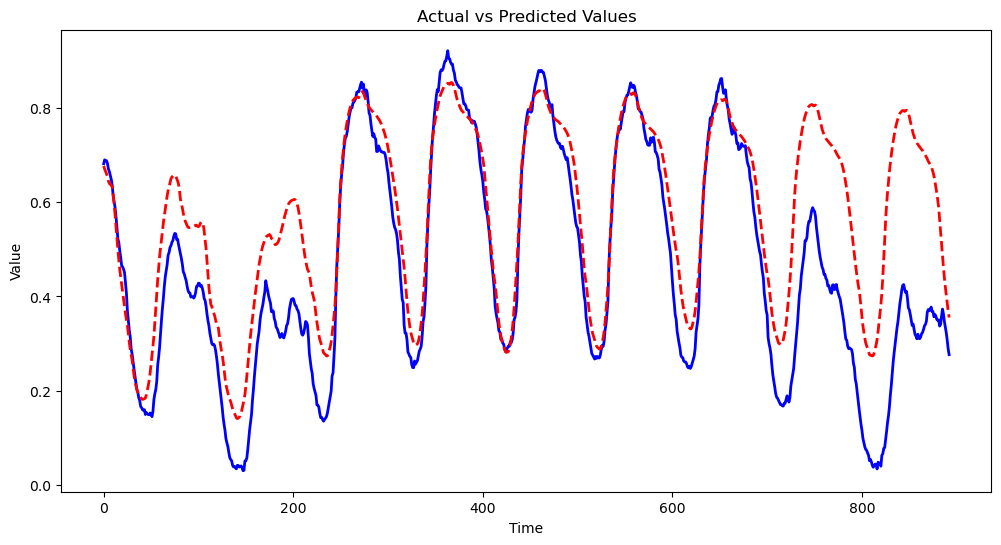

In [50]:

tscv = TimeSeriesSplit(n_splits=5)
split_results = []

for train_index, test_index in tscv.split(X_sequences):
    try:
        X_train, X_test = X_sequences[train_index], X_sequences[test_index]
        y_train, y_test = y_sequences[train_index], y_sequences[test_index]
    except IndexError as e:
        print(f"IndexError: {e}")
        print(f"train_index: {train_index}")
        print(f"test_index: {test_index}")
        print(f"X_sequences shape: {X_sequences.shape}")
        print(f"y_sequences shape: {y_sequences.shape}")
        break
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[early_stopping], verbose=1)
    
    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    split_results.append(loss)

# Average performance over all splits
average_loss = np.mean(split_results)
print(f'Average validation loss over all splits: {average_loss}')

# Assuming the model performed well, we now train on the entire dataset (except the final test set)
train_size = int(len(X_sequences) * 0.9)
X_train_final, X_test_final = X_sequences[:train_size], X_sequences[train_size:]
y_train_final, y_test_final = y_sequences[:train_size], y_sequences[train_size:]

# Train the final model on all available data
model_final = Sequential()
model_final.add(LSTM(50, return_sequences=True, input_shape=(X_train_final.shape[1], X_train_final.shape[2])))
model_final.add(Dropout(0.2))
model_final.add(LSTM(50, return_sequences=False))
model_final.add(Dropout(0.2))
model_final.add(Dense(25))
model_final.add(Dense(1))

model_final.compile(optimizer='adam', loss='mean_squared_error')

early_stopping_final = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_final.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_data=(X_test_final, y_test_final),
                callbacks=[early_stopping_final], verbose=1)

# Final evaluation
final_loss = model_final.evaluate(X_test_final, y_test_final)
print(f'Final test loss: {final_loss}')

y_pred = model_final.predict(X_test_final)
#print(y_pred)
#y_pred = y_pred.flatten()
#print(y_pred)
# If your data was normalized, don't forget to inverse-transform y_pred and y_test_final back to original scale
# Assuming you used MinMaxScaler or similar normalization technique
# Example:
# y_pred = scaler.inverse_transform(y_pred)
# y_test_final = scaler.inverse_transform(y_test_final)

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_final, label='Actual Values', color='blue', linewidth=2)
plt.plot(y_pred, label='Predicted Values', color='red', linewidth=2, linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('Value')
